In [1]:
from helpers.similarity_generator import get_algorithm_by_name
from metrics import metrics
import pandas as pd
from tabulate import tabulate

stats = {}
table = []
headers = ['Algorithm', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC', 'TP', 'TN', 'FP', 'FN']

for name in ['LCS', 'COS', 'LEV', 'LSH', 'D2VK', 'WMDK']:
    alg = get_algorithm_by_name(name)
    s = metrics.train_test(metrics.get_metrics)('data/train.csv', 'data/test.csv', alg, True, name)
    stats[name] = s
    table.append((name, s['accuracy'], s['precision'], s['recall'], s['f1'], s['roc'], s['tp'], s['tn'], s['fp'], s['fn']))

name = 'SiamX2'
siamx = get_algorithm_by_name(name)
df_train = pd.read_csv('data/train.csv', index_col=0)
df_test = pd.read_csv('data/test.csv', index_col=0)
siamx.train(df_train, True, name)
y_pred = siamx.run_similarity(df_test)
y_test = df_test['label'].to_numpy()
s = metrics.get_metrics(siamx, y_test, y_pred)
stats[name] = s
table.append((name, s['accuracy'], s['precision'], s['recall'], s['f1'], s['roc'], s['tp'], s['tn'], s['fp'], s['fn']))

print(tabulate(table, headers, tablefmt='grid', floatfmt='.2f'))

Using TensorFlow backend.
Threshold = 0.5833, train accuracy = 0.9696
Threshold = 0.7762, train accuracy = 0.9269
Threshold = 0.4439, train accuracy = 0.9122
Threshold = 0.0600, train accuracy = 0.9600
Threshold = 0.7105, train accuracy = 0.9299
Threshold = -8.7397, train accuracy = 0.9555
Threshold = 0.9008, train accuracy = 0.9899
+-------------+------------+-------------+----------+------+-------+------+------+------+------+
| Algorithm   |   Accuracy |   Precision |   Recall |   F1 |   ROC |   TP |   TN |   FP |   FN |
+=============+============+=============+==========+======+=======+======+======+======+======+
| LCS         |       0.95 |        0.98 |     0.92 | 0.95 |  1.00 |  339 |  360 |    8 |   29 |
+-------------+------------+-------------+----------+------+-------+------+------+------+------+
| COS         |       0.89 |        0.99 |     0.79 | 0.88 |  0.99 |  289 |  366 |    2 |   79 |
+-------------+------------+-------------+----------+------+-------+------+------+-

In [2]:
import pandas as pd 
import numpy as np 
import time

df = pd.read_csv('data/pairs/junit4.csv', index_col=0, na_filter=False)
X = list(zip(df.comment1, df.comment2))
times = {}

for name in ['LCS', 'COS', 'LEV', 'LSH', 'D2VK', 'WMDK', 'SiamX2']:
    alg = get_algorithm_by_name(name, load=True)

    start_time = time.process_time()
    if name == 'SiamX2':
        scores = np.array(alg.run_similarity(df))
    else:
        scores = np.array(alg.run_similarity(X))
    times[name] = time.process_time() - start_time

    predictions = alg.predict(scores)
    df_pred = df.copy()
    df_pred.drop(columns=['name1', 'name2'], inplace=True)
    df_pred.insert(len(df_pred.columns), 'score', scores)
    df_pred.insert(len(df_pred.columns), 'pred', predictions)
    df_pred.sort_values(by='score', ascending=False, inplace=True)
    df_pred.to_csv('data/pred/' + name + '.csv')

    print(name, times[name])
    print(df_pred.groupby('pred').count())

LCS 15.346621078000013
      comment1  comment2   meta1   meta2   label   score
pred                                                    
0       179409    179409  179409  179409  179409  179409
1          972       972     972     972     972     972
COS 18.71035759899999
      comment1  comment2   meta1   meta2   label   score
pred                                                    
0       179817    179817  179817  179817  179817  179817
1          564       564     564     564     564     564
LEV 161.394464712
      comment1  comment2   meta1   meta2   label   score
pred                                                    
0       178359    178359  178359  178359  178359  178359
1         2022      2022    2022    2022    2022    2022
LSH 625.3815550520001
      comment1  comment2   meta1   meta2   label   score
pred                                                    
0       179077    179077  179077  179077  179077  179077
1         1304      1304    1304    1304    1304    1304
D2V

In [13]:
import pickle
import pandas as pd 

with open('data/up/accepted/all.pkl', 'rb') as f:
    all = pickle.load(f)

for name in ['LCS', 'COS', 'LEV', 'LSH', 'D2VK', 'WMDK', 'SiamX2']:
    df = pd.read_csv('data/pred/' + name + '.csv', index_col=0)
    df.loc[all, 'label'] = 1
    df.to_csv('data/pred/part/' + name + '.csv')

In [4]:
import pandas as pd 
import numpy as np 
from helpers.similarity_generator import get_algorithm_by_name

df = pd.read_csv('data/test.csv', index_col=0, na_filter=False)
X = list(zip(df.comment1, df.comment2))

for name in ['LCS', 'COS', 'LEV', 'LSH', 'D2VK', 'WMDK', 'SiamX2']:
    alg = get_algorithm_by_name(name, load=True)
    if name == 'SiamX2':
        scores = np.array(alg.run_similarity(df))
    else:
        scores = np.array(alg.run_similarity(X))
    df_pred = df.copy()
    df_pred.insert(len(df_pred.columns), 'score', scores)
    df_pred.to_csv('data/pred/test/' + name + '.csv')

Using TensorFlow backend.


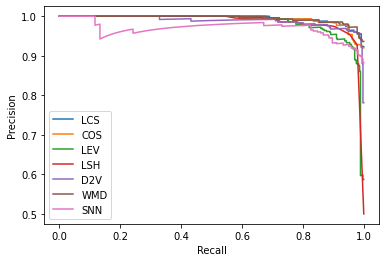

In [8]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot

for name, title in zip(['LCS', 'COS', 'LEV', 'LSH', 'D2VK', 'WMDK', 'SiamX2'],
    ['LCS', 'COS', 'LEV', 'LSH', 'D2V', 'WMD', 'SNN']):
    df = pd.read_csv('data/pred/test/' + name + '.csv', index_col=0)
    precision, recall, thresholds = precision_recall_curve(df.label, df.score)
    pyplot.plot(recall, precision, label=title)

pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()